In [1]:
import matplotlib.pyplot as plt
import numpy as np
from data import *
from hyperparameters import *
from small_dim import *
from optimal_bounds import *
import pandas as pd
import scipy.stats as stat

## Erreur en fonction de $n$

In [2]:
p = 100
ratio = 0.2
tt = 0
hp = HyperParameters(1)
NL = np.array([2,5,10,20,50,100,200])
n = len(NL)
nb_iter = 100
E_sup_emp = np.zeros((n,nb_iter))
E_opt_emp = np.zeros((n,nb_iter))
E_sup_th = np.zeros((n,nb_iter))
E_opt_th = np.zeros((n,nb_iter))
best = np.zeros(n)

In [3]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1

In [4]:
for i in range(n):
    nl = NL[i]
    nu = int(nl*(1-ratio)/ratio)
    for j in range(nb_iter):
        data = DataDegree(p,[[nl,nl]],[[nu,nu]])
        data.create_gaussian(MU)
        data.center()
        Mcal = data.Mcal('true',MU)
        hp.compute_lambda(data,'true',MU)
        Sigmas = 4/(np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True)@np.linalg.norm(MU[:,0]-MU[:,1],axis=1,keepdims=True).T)
        M = hp.lbd/Sigmas
        
        hp.compute_lambda(data,'ord2',MU)
        q = solution(data, M)
        best[i] = 1-stat.norm.cdf(np.sqrt(q[0]))
        hp.compute_alpha0(data)
        
        data.degrees[0][0] = np.concatenate((np.ones(data.NL[0,0]),np.zeros(data.NL[0,1])))
        data.degrees[0][1] = np.concatenate((np.zeros(data.NL[0,0]),np.ones(data.NL[0,1])))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_opt_th[i,j] = error_opti(a1, a2, B)
        E_opt_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
        
        hp.alpha = 1e5*hp.alpha
        a1, a2, B = small_dim(data, hp, Mcal, tt)
        E_sup_th[i,j] = error_opti(a1, a2, B)
        E_sup_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
    print(nl)

2
5
10
20
50
100
200


In [5]:
m_sup_emp = np.mean(E_sup_emp,axis=1)
s_sup_emp = np.sqrt(np.var(E_sup_emp,axis=1))/np.sqrt(nb_iter)
m_opt_emp = np.mean(E_opt_emp,axis=1)
s_opt_emp = np.sqrt(np.var(E_opt_emp,axis=1))/np.sqrt(nb_iter)
m_sup_th = np.mean(E_sup_th,axis=1)
m_opt_th = np.mean(E_opt_th,axis=1)
LOG_N = np.log(NL)-np.log(ratio)

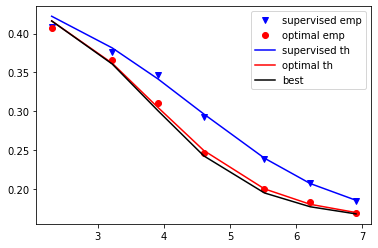

In [6]:
plt.plot(LOG_N, m_sup_emp, 'v', label='supervised emp', color='b')
plt.plot(LOG_N, m_opt_emp, 'o', label='optimal emp', color='r')
plt.plot(LOG_N, m_sup_th, '-', label='supervised th', color='b')
plt.plot(LOG_N, m_opt_th, '-', label='optimal th', color='r')
#plt.errorbar(LOG_N, m_sup_emp, s_sup_emp, color='b', capsize=4, linestyle='')
#plt.errorbar(LOG_N, m_opt_emp, s_opt_emp, color='r', capsize=4, linestyle='')
plt.plot(LOG_N, best, '-', label='best', color='k')
plt.legend()

In [7]:
plt.plot(LOG_N, m_opt_th-best, '-', label='gap to best', color='k')

In [8]:
n_perf = pd.DataFrame({'log_n': LOG_N, 'best': best, 'm_opt_th': m_opt_th, 'm_sup_th': m_sup_th,  'm_opt_emp': m_opt_emp, 'm_sup_emp': m_sup_emp, 's_opt_emp': s_opt_emp, 's_sup_emp': s_sup_emp})  
n_perf.to_csv('DATA/n_perf.dat',sep=' ',index=False)

## Erreur en fonction de la fiabilité des étiquettes "incertaines"

In [9]:
p = 200
nl = 500
nu = 200
tt = 0
data = DataDegree(p,[[nl,nl]],[[nu,nu]])
hp = HyperParameters(1)
pas = 5
FIAB = np.arange(50,100+pas,pas)/100
n = len(FIAB)
nb_iter = 20
E_1_emp = np.zeros((n,nb_iter))
E_2_emp = np.zeros((n,nb_iter))
E_3_emp = np.zeros((n,nb_iter))
E_1_th = np.zeros((n,nb_iter))
E_2_th = np.zeros((n,nb_iter))
E_3_th = np.zeros((n,nb_iter))

In [10]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1
Mcal = data.Mcal('true',MU)

In [11]:
for i in range(n):
    conf = FIAB[i] # Confiance dans les  données labelisées "incertaines"
    nf = 50 # Nombre de données labelisées "fiables"
    ni = nl-nf # Nombre de données labelisées "incertaines"
    n1 = int(conf*ni)
    n2 = ni-n1
    for j in range(nb_iter):
        data.create_gaussian(MU)
        data.center()
        hp.compute_alpha0(data)
        
        # étiquetage naïf
        data.degrees[0][0] = np.concatenate((np.ones(nf),np.ones(n1),np.zeros(n2),np.zeros(nf),np.zeros(n1),np.ones(n2)))
        data.degrees[0][1] = np.concatenate((np.zeros(nf),np.zeros(n1),np.ones(n2),np.ones(nf),np.ones(n1),np.zeros(n2)))
        K_bar = np.zeros((2,2))
        K_bar[0,0] = data.NL[0,0]/data.N[0,0]
        K_bar[1,1] = data.NL[0,1]/data.N[0,1]
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_1_th[i,j] = error_opti(a1, a2, B)
        E_1_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
        
        # étiquetage adapté
        data.degrees[0][0] = np.concatenate((np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2),np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2)))
        data.degrees[0][1] = np.concatenate((np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2),np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2)))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_2_th[i,j] = error_opti(a1, a2, B)
        E_2_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
        
        # étiquetage oracle
        data.degrees[0][0] = np.concatenate((np.ones(data.NL[0,0]),np.zeros(data.NL[0,1])))
        data.degrees[0][1] = np.concatenate((np.zeros(data.NL[0,0]),np.ones(data.NL[0,1])))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_3_th[i,j] = error_opti(a1, a2, B)
        E_3_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
    print(conf)

0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


In [12]:
m_1_emp = np.mean(E_1_emp,axis=1)
s_1_emp = np.sqrt(np.var(E_1_emp,axis=1))/np.sqrt(nb_iter)
m_2_emp = np.mean(E_2_emp,axis=1)
s_2_emp = np.sqrt(np.var(E_2_emp,axis=1))/np.sqrt(nb_iter)
m_3_emp = np.mean(E_3_emp,axis=1)
s_3_emp = np.sqrt(np.var(E_3_emp,axis=1))/np.sqrt(nb_iter)
m_1_th = np.mean(E_1_th,axis=1)
m_2_th = np.mean(E_2_th,axis=1)
m_3_th = np.mean(E_3_th,axis=1)

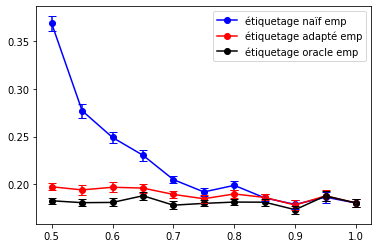

In [13]:
plt.plot(FIAB, m_1_emp, 'o-', label='étiquetage naïf emp', color='b')
plt.plot(FIAB, m_2_emp, 'o-', label='étiquetage adapté emp', color='r')
plt.plot(FIAB, m_3_emp, 'o-', label='étiquetage oracle emp', color='k')
#plt.plot(FIAB, m_1_th, '-', label='étiquetage naïf th', color='b')
#plt.plot(FIAB, m_2_th, '-', label='étiquetage adapté th', color='r')
#plt.plot(FIAB, m_3_th, '-', label='étiquetage oracle th', color='k')
plt.errorbar(FIAB, m_1_emp, s_1_emp, color='b', capsize=4, linestyle='')
plt.errorbar(FIAB, m_2_emp, s_2_emp, color='r', capsize=4, linestyle='')
plt.errorbar(FIAB, m_3_emp, s_3_emp, color='k', capsize=4, linestyle='')
plt.legend()

In [14]:
fiab_perf = pd.DataFrame({'fiab': FIAB, 'm_1_th': m_1_th, 'm_2_th': m_2_th, 'm_3_th': m_3_th, 'm_1_emp': m_1_emp, 'm_2_emp': m_2_emp, 'm_3_emp': m_3_emp, 's_1_emp': s_1_emp, 's_2_emp': s_2_emp, 's_3_emp': s_3_emp})  
fiab_perf.to_csv('DATA/fiab_perf.dat',sep=' ',index=False)

On met en évidence le fait que si une partie des données est mal labelisée, l'erreur explose. Utiliser des degrés de confiance sur les données moins fiable permet de contenir cette erreur.  

## Erreur en fonction du nombre de données "incertaines"

In [15]:
p = 100
nf = 50
nu = 200
tt = 0
data = DataDegree(p,[[nl,nl]],[[nu,nu]])
hp = HyperParameters(1)
conf = 0.8
pas = 50
NI = np.array([1,2,5,10,20,50,80,150,300,400,700,1000,1500,2000,2500,3000])
n = len(NI)
nb_iter = 1
E_1_emp = np.zeros((n,nb_iter))
E_2_emp = np.zeros((n,nb_iter))
E_3_emp = np.zeros((n,nb_iter))
E_1_th = np.zeros((n,nb_iter))
E_2_th = np.zeros((n,nb_iter))
E_3_th = np.zeros((n,nb_iter))

In [16]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1
Mcal = data.Mcal('true',MU)

In [17]:
for i in range(n):
    ni = NI[i]
    nl = nf+ni
    n1 = int(conf*ni)
    n2 = ni-n1
    data = DataDegree(p,[[nl,nl]],[[nu,nu]])
    for j in range(nb_iter):
        data.create_gaussian(MU)
        data.center()
        hp.compute_alpha0(data)
        
        # étiquetage adapté
        data.degrees[0][0] = np.concatenate((np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2),np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2)))
        data.degrees[0][1] = np.concatenate((np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2),np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2)))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_1_th[i,j] = error_opti(a1, a2, B)
        E_1_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
        
        # étiquetage restreint
        data.degrees[0][0] = np.concatenate((np.ones(nf),np.zeros(ni),np.zeros(nf),np.zeros(ni)))
        data.degrees[0][1] = np.concatenate((np.zeros(nf),np.zeros(ni),np.ones(nf),np.zeros(ni)))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_2_th[i,j] = error_opti(a1, a2, B)
        E_2_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
        
        # étiquetage oracle
        data.degrees[0][0] = np.concatenate((np.ones(data.NL[0,0]),np.zeros(data.NL[0,1])))
        data.degrees[0][1] = np.concatenate((np.zeros(data.NL[0,0]),np.ones(data.NL[0,1])))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        E_3_th[i,j] = error_opti(a1, a2, B)
        E_3_emp[i,j] = data.error_emp(hp, labels_opti(a1, a2, B), tt, threshold=0)
    print(ni)

1
2
5
10
20
50
80
150
300
400
700
1000
1500
2000
2500
3000


In [18]:
m_1_th = np.mean(E_1_th,axis=1)
m_2_th = np.mean(E_2_th,axis=1)
m_3_th = np.mean(E_3_th,axis=1)

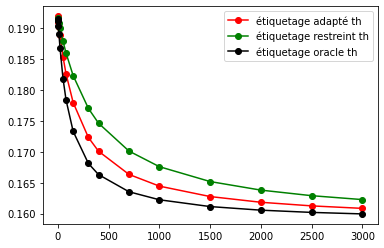

In [19]:
plt.plot(NI, m_1_th, 'o-', label='étiquetage adapté th', color='r')
plt.plot(NI, m_2_th, 'o-', label='étiquetage restreint th', color='g')
plt.plot(NI, m_3_th, 'o-', label='étiquetage oracle th', color='k')
plt.legend()

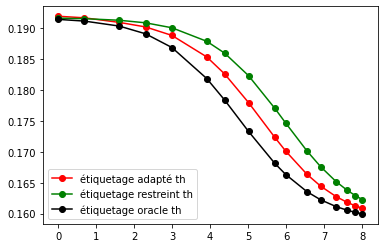

In [20]:
plt.plot(np.log(NI), m_1_th, 'o-', label='étiquetage adapté th', color='r')
plt.plot(np.log(NI), m_2_th, 'o-', label='étiquetage restreint th', color='g')
plt.plot(np.log(NI), m_3_th, 'o-', label='étiquetage oracle th', color='k')
plt.legend()

In [21]:
adapte_vs_restreint = pd.DataFrame({'ni': NI, 'm_adapte': m_1_th, 'm_restreint': m_2_th, 'm_oracle': m_3_th})  
adapte_vs_restreint.to_csv('DATA/adapte_vs_restreint.dat',sep=' ',index=False)

On met en évidence le fait qu'on a intérêt à avoir des données mal labelisée plutôt que non labelisées, à condition que l'incertitude sur cette labelisation soit correctement estimée.

## Nombre de données incertaines pour compenser le manque de données labelisées

In [22]:
p = 200
nl_ini = 50
nu = 200
tt = 0
hp = HyperParameters(1)
m = 5
n = 10
NI = np.zeros((m,n))
n_bcp = 3000

In [23]:
MU = np.zeros((1,2,p))
MU[0,0,0] = -1
MU[0,1,0] = 1

In [24]:
CONF = np.array([0.5,0.6,0.75,0.9,1])
NL = np.zeros((m,n),dtype=int)
# Création des données qui serviront de base commune
data_base = DataDegree(p,[[n_bcp,n_bcp]],[[nu,nu]])
data_base.create_gaussian(MU)
Mcal = data_base.Mcal('true',MU)
for i in range(m):
    conf = CONF[i]
    NL[i,0], NL[i,-1] = 20, 400
    NL[i,1:n-1] = np.array(20+np.random.rand(n-2)*350,dtype=int)
    for j in range(n):
        # Calcul de l'erreur de référence
        err_base = 0
        nf = nl_ini+NL[i,j]
        data = DataDegree(p,[[nf,nf]],[[nu,nu]])
        for j1 in range(2):
            data.labeled[0][j1] = data_base.labeled[0][j1][:,0:nf]
            data.unlabeled[0][j1] = data_base.unlabeled[0][j1]
        data.degrees[0][0] = np.concatenate((np.ones(nf),np.zeros(nf)))
        data.degrees[0][1] = np.concatenate((np.zeros(nf),np.ones(nf)))
        K_bar = np.zeros((2,2))
        for j2 in range(2):
            K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
            K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
        hp.compute_alpha0(data)
        hp.optim_alpha(data,Mcal,tt,K_bar)
        a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
        err_base = error_opti(a1, a2, B)
        # Calcul du nombre de données "incertaines" pour battre l'erreur de référence
        ni = 0
        pas = int(NL[i,j]/20)
        nf = nl_ini 
        new_err = err_base+1
        while new_err>err_base:
            data = DataDegree(p,[[nf+ni,nf+ni]],[[nu,nu]])
            for j1 in range(2):
                data.labeled[0][j1] = data_base.labeled[0][j1][:,0:nf+ni]
                data.unlabeled[0][j1] = data_base.unlabeled[0][j1]
            n1 = int(conf*ni)
            n2 = ni-n1
            data.degrees[0][0] = np.concatenate((np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2),np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2)))
            data.degrees[0][1] = np.concatenate((np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2),np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2)))
            K_bar = np.zeros((2,2))
            for j2 in range(2):
                K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
                K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
            hp.compute_alpha0(data)
            hp.optim_alpha(data,Mcal,tt,K_bar)
            a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
            new_err = error_opti(a1, a2, B)
            ni += pas
            if ni==650:
                ni = 651
        NI[i,j] = ni - pas
    print(CONF[i])

0.5
0.6
0.75
0.9
1.0


In [25]:
for i in range(m):
    NL[i].sort()
    NI[i].sort()

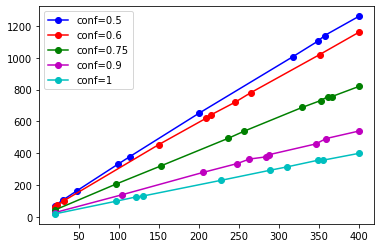

In [26]:
plt.plot(NL[0], NI[0], '-o', label='conf=0.5', color='b')
plt.plot(NL[1], NI[1], '-o', label='conf=0.6', color='r')
plt.plot(NL[2], NI[2], '-o', label='conf=0.75', color='g')
plt.plot(NL[3], NI[3], '-o', label='conf=0.9', color='m')
plt.plot(NL[4], NI[4], '-o', label='conf=1', color='c')
plt.legend()

In [27]:
nb_donnees_sup = pd.DataFrame({'nl1': NL[0], 'ni1': NI[0], 'nl2': NL[1], 'ni2': NI[1], 'nl3': NL[2], 'ni3': NI[2], 'nl4': NL[3], 'ni4': NI[3], 'nl5': NL[4], 'ni5': NI[4]})  
nb_donnees_sup.to_csv('DATA/nb_donnees_sup.dat',sep=' ',index=False)

## Nombre de données incertaines par donnée labelisée

In [28]:
p = 200
nl_ini = 50
nu = 200
tt = 0
hp = HyperParameters(1)
m = 10
n = 5
NI = np.zeros((3,m,n))
n_bcp = 3000
H = [1,2,5]

In [29]:
for h in range(3):
    MU = np.zeros((1,2,p))
    MU[0,0,0] = -H[h]
    MU[0,1,0] = H[h]
    Mcal = data.Mcal('true',MU)
    CONF = np.linspace(0.5,1,m)
    NL = np.array([20,50,100,200,400])
    # Création des données qui serviront de base commune
    data_base = DataDegree(p,[[n_bcp,n_bcp]],[[nu,nu]])
    data_base.create_gaussian(MU)
    for i in range(m):
        conf = CONF[i]
        for j in range(n):
            # Calcul de l'erreur de référence
            err_base = 0
            nf = nl_ini+NL[j]
            data = DataDegree(p,[[nf,nf]],[[nu,nu]])
            for j1 in range(2):
                data.labeled[0][j1] = data_base.labeled[0][j1][:,0:nf]
                data.unlabeled[0][j1] = data_base.unlabeled[0][j1]
            data.degrees[0][0] = np.concatenate((np.ones(nf),np.zeros(nf)))
            data.degrees[0][1] = np.concatenate((np.zeros(nf),np.ones(nf)))
            K_bar = np.zeros((2,2))
            for j2 in range(2):
                K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
                K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
            hp.compute_alpha0(data)
            hp.optim_alpha(data,Mcal,tt,K_bar)
            a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
            err_base = error_opti(a1, a2, B)
            # Calcul du nombre de données "incertaines" pour battre l'erreur de référence
            ni = 0
            pas = int(NL[j]/20)
            nf = nl_ini 
            new_err = err_base+1
            while new_err>err_base:
                data = DataDegree(p,[[nf+ni,nf+ni]],[[nu,nu]])
                for j1 in range(2):
                    data.labeled[0][j1] = data_base.labeled[0][j1][:,0:nf+ni]
                    data.unlabeled[0][j1] = data_base.unlabeled[0][j1]
                n1 = int(conf*ni)
                n2 = ni-n1
                data.degrees[0][0] = np.concatenate((np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2),np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2)))
                data.degrees[0][1] = np.concatenate((np.zeros(nf),(1-conf)*np.ones(n1),conf*np.ones(n2),np.ones(nf),conf*np.ones(n1),(1-conf)*np.ones(n2)))
                K_bar = np.zeros((2,2))
                for j2 in range(2):
                    K_bar[0,j2] = data.NL[0,0]/data.N[0,0]*np.mean(data.degrees[0][j2][0:data.NL[0,0]])
                    K_bar[1,j2] = data.NL[0,1]/data.N[0,1]*np.mean(data.degrees[0][j2][data.NL[0,0]:data.NL[0,0]+data.NL[0,1]])
                hp.compute_alpha0(data)
                hp.optim_alpha(data,Mcal,tt,K_bar)
                a1, a2, B = small_dim_deg(data, hp, Mcal, tt, K_bar)
                new_err = error_opti(a1, a2, B)
                ni += pas
                if ni==600:
                    ni = 601
            NI[h,i,j] = ni - pas
    print(h)

0
1
2


In [30]:
P = np.zeros((3,m,2))
Pente = [[],[],[]]
for h in range(3):
    for i in range(m):
        P[h,i] = np.polyfit(NL,NI[h,i],1)
        Pente[h].append(P[h,i,0])
Pente = np.array(Pente)

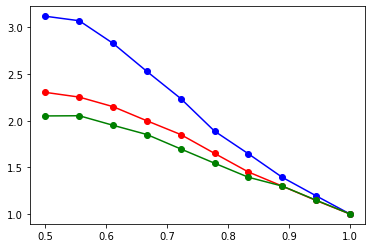

In [31]:
plt.plot(CONF, Pente[0], 'o-', label='conf=0.5', color='b')
plt.plot(CONF, Pente[1], 'o-', label='conf=0.5', color='r')
plt.plot(CONF, Pente[2], 'o-', label='conf=0.5', color='g')

In [32]:
pente = pd.DataFrame({'conf': CONF, 'pente_1': Pente[0], 'pente_2': Pente[1], 'pente_3': Pente[2]})
pente.to_csv('DATA/pente.dat',sep=' ',index=False)